In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy as sp
from tqdm import tqdm
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from helpers import (Fy, find_closest_element,  compute_coverage, #predict_single_density,
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)
from density_predictor_class_val import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/B_zeta_val.npy')
beta = np.genfromtxt('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/beta.csv', delimiter = ',')
#B_zeta = B_zeta.reshape(B_zeta.shape[0], B_zeta.shape[])
true_y = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/labels_val.npy')
true_z = np.load('../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/tr_labels_val.npy')

B_zeta = B_zeta[np.abs(true_y) < 50,:] 
true_z = true_z[np.abs(true_y) < 50]
true_y = true_y[np.abs(true_y) < 50]

density_path = '../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 500

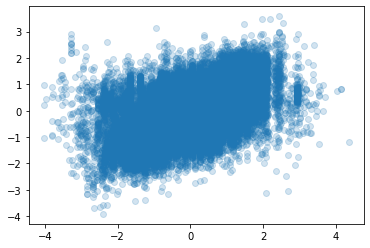

In [3]:
plt.scatter(true_z, B_zeta.dot(beta), alpha = 0.2)

(-20.0, 20.0)

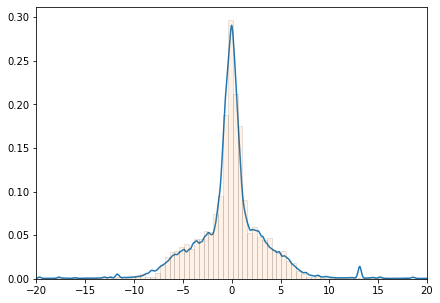

In [4]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
plt.plot(density['axes'], density['pdf'])
ax.hist(true_y, bins=200, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.set_xlim(-20,20)

In [5]:
dens = density_predictor(B_zeta, true_y, density, no_points)

In [6]:
result_va_ridge = dens.get_density('va_ridge')
result_hmc_ridge = dens.get_density('hmc_ridge')

  0%|          | 85/94805 [00:00<01:51, 846.91it/s]

computing densities for each observation


  1%|          | 650/94805 [00:00<00:14, 6495.00it/s]

computing mean prediction for each observation


  2%|▏         | 1537/94805 [00:00<00:06, 15364.04it/s]

computing variance prediction for each observation


100%|██████████| 94805/94805 [00:06<00:00, 15714.02it/s]


In [ ]:
result_va_horse = dens.get_density('va_horseshoe')
result_hmc_horse = dens.get_density('hmc_horseshoe')

In [ ]:
z_pred = B_zeta.dot(beta) 
y_pred = np.array([density.loc[find_closest_element(norm.cdf(i), density['cdf']), 'axes'] for i in tqdm(z_pred)])

In [ ]:
plt.scatter(true_y, y_pred , alpha = 0.5)

In [ ]:
print('Validation Performance: ' +
      '\nMSE:' +
     '\n CIL VA/Ridge: ' + str(np.mean((true_y - np.array(result_va_ridge['mean predictions']))**2)) +
     '\n CIL HMC/Ridge: ' + str(np.mean((true_y - np.array(result_hmc_ridge['mean prediction']))**2)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean((true_y - np.array(result_va_horse['mean prediction']))**2)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean((true_y - np.array(result_hmc_horse['mean prediction']))**2)) +
     '\n CIL No Bayes: ' + str(np.mean((true_y - y_pred)**2)) +
     '\n CIL Benchmark: ' + str(np.mean((true_y - 0)**2)) +
      
    '\nMAE:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])))) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])))) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])))) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])))) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred))) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0))) +
      
      '\nAccuracy:' +
     '\n CIL VA/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_va_ridge['mean predictions'])) < 6)) +
     '\n CIL HMC/Ridge: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_ridge['mean prediction'])) < 6)) +
     '\n CIL VA/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_va_horse['mean prediction'])) < 6)) +
     '\n CIL HMC/Horseshoe: ' + str(np.mean(np.abs(true_y - np.array(result_hmc_horse['mean prediction'])) < 6)) +
     '\n CIL No Bayes: ' + str(np.mean(np.abs(true_y - y_pred) < 6)) +
     '\n CIL Benchmark: ' + str(np.mean(np.abs(true_y - 0) < 6))
     )

In [ ]:
df = pd.DataFrame({'va_ridge' : result_va_ridge['densities'],
                 'hmc_ridge' : result_hmc_ridge['densities'],
                 'va_horse' : result_va_horse['densities'],
                 'hmc_horse' : result_hmc_horse['densities']})

In [ ]:
df.to_csv('../../../data/commaai/predictions/cil/densities.csv')